In [ ]:
from google.colab import files
files.upload()

In [2]:
import json
import pandas as pd
import numpy as np

with open("clinical.project-tcga-lihc.2025-09-06.json") as f:
    clinical = json.load(f)

print("Loaded", len(clinical), "clinical cases")

Loaded 377 clinical cases


In [3]:
def recursive_search(d, patterns):
    if isinstance(d, dict):
        for k, v in d.items():
            if any(p in str(k).lower() or p in str(v).lower() for p in patterns):
                return True
            if recursive_search(v, patterns):
                return True
    elif isinstance(d, list):
        for item in d:
            if recursive_search(item, patterns):
                return True
    return False

def extract_label(case):
    if recursive_search(case, ["hepatitis b", "hbv"]):
        return "HBV"
    elif recursive_search(case, ["hepatitis c", "hcv"]):
        return "HCV"
    else:
        return "NonViral"

records = []
for case in clinical:
    records.append({
        "case_id": case.get("submitter_id"),
        "label": extract_label(case)
    })

labels_df = pd.DataFrame(records)
print("Class counts after label extraction:")
print(labels_df["label"].value_counts())

Class counts after label extraction:
label
HBV         234
NonViral     97
HCV          46
Name: count, dtype: int64


In [4]:
labels_df = labels_df[labels_df["label"].isin(["HBV", "NonViral"])].dropna()
print("Filtered to HBV vs NonViral:")
print(labels_df["label"].value_counts())

Filtered to HBV vs NonViral:
label
HBV         234
NonViral     97
Name: count, dtype: int64


In [5]:
features = []
for case in clinical:
    rec = {"case_id": case.get("submitter_id")}
    diag = case.get("diagnoses", [{}])[0]
    demo = case.get("demographic", {})

    rec["age"] = demo.get("age_at_index")
    rec["gender"] = demo.get("gender")
    rec["stage"] = diag.get("ajcc_pathologic_stage")
    rec["tumor_grade"] = diag.get("tumor_grade")
    features.append(rec)

feat_df = pd.DataFrame(features)

merged = labels_df.merge(feat_df, on="case_id")
print("Merged dataset shape:", merged.shape)
print("Final class distribution:")
print(merged["label"].value_counts())

Merged dataset shape: (331, 6)
Final class distribution:
label
HBV         234
NonViral     97
Name: count, dtype: int64


In [6]:
from sklearn.model_selection import train_test_split

X = merged.drop(columns=["case_id", "label"])
y = merged["label"].map({"HBV":1, "NonViral":0})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("Train distribution:", y_train.value_counts().to_dict())
print("Test distribution:", y_test.value_counts().to_dict())

Train distribution: {1: 163, 0: 68}
Test distribution: {1: 71, 0: 29}


In [7]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_cols = ["age"]
cat_cols = ["gender", "stage", "tumor_grade"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    ]
)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#lr
lr = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=200, class_weight="balanced"))
])

#rf
rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=42
    ))
])

#trn both
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'stage',
                                                   'tumor_grade'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, random_state=42))])

=== Logistic Regression ===
ROC-AUC: 0.624
F1: 0.712
Accuracy: 0.62
Confusion Matrix:
 [[15 14]
 [24 47]]


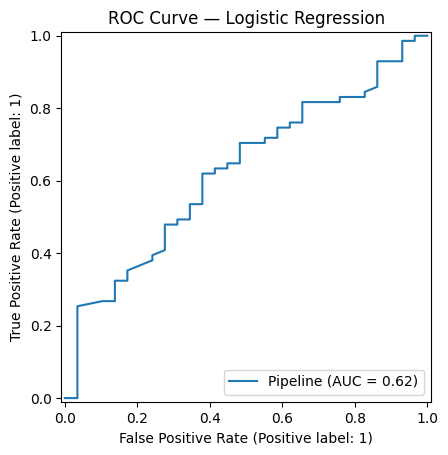

=== Random Forest ===
ROC-AUC: 0.595
F1: 0.792
Accuracy: 0.69
Confusion Matrix:
 [[10 19]
 [12 59]]


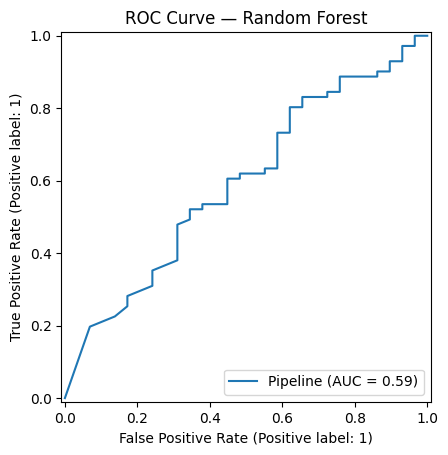

,Model,ROC-AUC,F1,Accuracy
0,Logistic Regression,0.624089,0.712121,0.62
1,Random Forest,0.594706,0.791946,0.69


In [9]:
from sklearn.metrics import (
    roc_auc_score, f1_score, accuracy_score,
    confusion_matrix, RocCurveDisplay
)
import matplotlib.pyplot as plt

def evaluate(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"=== {name} ===")
    print("ROC-AUC:", round(auc,3))
    print("F1:", round(f1,3))
    print("Accuracy:", round(acc,3))
    print("Confusion Matrix:\n", cm)

    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"ROC Curve — {name}")
    plt.show()

    return {"Model":name, "ROC-AUC":auc, "F1":f1, "Accuracy":acc}

res_lr = evaluate(lr, X_test, y_test, "Logistic Regression")
res_rf = evaluate(rf, X_test, y_test, "Random Forest")

results = pd.DataFrame([res_lr, res_rf])
results

In [10]:
# Get feature names after preprocessing
ohe = lr.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
feature_names = num_cols + list(ohe.get_feature_names_out(cat_cols))

# Logistic Regression coefficients
coefs = lr.named_steps["classifier"].coef_[0]
feat_lr = pd.DataFrame({"feature":feature_names, "coef":coefs})
feat_lr["abs_coef"] = feat_lr["coef"].abs()
feat_lr = feat_lr.sort_values("abs_coef", ascending=False)

print("Top 10 Logistic Regression Features:")
print(feat_lr.head(10))

# Random Forest importances
importances = rf.named_steps["classifier"].feature_importances_
feat_rf = pd.DataFrame({"feature":feature_names, "importance":importances})
feat_rf = feat_rf.sort_values("importance", ascending=False)

print("\nTop 10 Random Forest Features:")
print(feat_rf.head(10))

Top 10 Logistic Regression Features:
             feature      coef  abs_coef
3      stage_Stage 0 -0.826836  0.826836
15    tumor_grade_G4  0.690386  0.690386
13    tumor_grade_G2 -0.643032  0.643032
16  tumor_grade_None  0.558407  0.558407
1      gender_female -0.545351  0.545351
2        gender_male  0.540368  0.540368
0                age -0.439771  0.439771
10    stage_Stage IV  0.410794  0.410794
6    stage_Stage III -0.391014  0.391014
9   stage_Stage IIIC  0.335989  0.335989

Top 10 Random Forest Features:
             feature  importance
0                age    0.650806
1      gender_female    0.050569
2        gender_male    0.042993
13    tumor_grade_G2    0.034374
4      stage_Stage I    0.030420
5     stage_Stage II    0.028392
14    tumor_grade_G3    0.026838
7   stage_Stage IIIA    0.025104
11        stage_None    0.023059
12    tumor_grade_G1    0.022258
